In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, precision_score, classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Introduction

The `Goals_model.ipynb` notebook is a comprehensive study aimed at predicting the total number of goals in a football match, with a specific emphasis on predicting whether the total goals would be 'Under' a certain threshold. The data used for this project is sourced from the top five football leagues and covers the seasons from 2008/2009 to 2014/2015.

Various machine learning models are trained, including Logistic Regression, Random Forest, Support Vector Machine, K-Nearest Neighbors, and Gradient Boosting. The Logistic Regression model is selected for its optimal balance between precision and recall, focusing on accurately predicting 'Under' goals. This is because most matches have 'Under' 2.5 goals, making this prediction highly valuable. The model undergoes a rigorous selection process, and its performance is further enhanced by tuning its hyperparameters and applying Principal Component Analysis (PCA) to reduce the dimensionality of the data.

The final part of the project involves evaluating the model's performance using the ROC AUC score, ROC curve, and confusion matrix. Despite its low precision, the model's ability to accurately predict 'Under' goals could still be beneficial for profiting from betting companies. However, the profitability of this model can only be definitively determined with data from betting companies.

In [2]:
matches_top_5 = pd.read_csv('matches_top_5_model.csv')

In [3]:
matches_top_5.head()

,match_api_id,season,stage,league_name,result,players_rating_difference,players_age_difference,home_team_form,away_team_form,home_team_rolling_goals,...,forwards_away_total_rating,home_team_outlier,away_team_outlier,goals_target,home_team_formations_Attacking,home_team_formations_Defensive,home_team_formations_Normal,away_team_formations_Attacking,away_team_formations_Defensive,away_team_formations_Normal
0,499343,2008/2009,3,Germany 1. Bundesliga,NW,-3.26,-1.60,2.25,0.0,1.25,...,78.0,0,0,U,False,True,False,False,True,False
1,499358,2008/2009,5,Germany 1. Bundesliga,Win,-3.73,-0.90,1.75,1.5,1.50,...,78.0,0,0,U,False,False,True,False,True,False
2,499378,2008/2009,7,Germany 1. Bundesliga,NW,-0.18,-0.09,1.50,1.0,2.00,...,78.0,0,0,O,False,True,False,False,True,False
3,499390,2008/2009,9,Germany 1. Bundesliga,Win,3.18,-4.36,1.50,1.5,2.75,...,78.0,0,0,U,False,False,True,False,True,False
4,499410,2008/2009,11,Germany 1. Bundesliga,NW,2.45,-1.00,2.40,1.2,2.20,...,148.0,0,0,O,False,False,True,False,False,True


We will create model that would predict Under or over in goals_target column.

# Machine Learning Models

We will use the following models to predict Under or Over:
- Logistic Regression
- Random Forest
- Support Vector Machine
- K-Nearest Neighbors
- Gradient Boosting

We will use the following metrics to evaluate the models:
- Precision
- Recall
- F1 Score

The primary metric of interest is precision, as we are interested in accurately predicting 'Under' goals. Then, we will use the best-performing model to improve the model.

In [4]:
drop_columns = ['league_name', 'season', 'result', 'match_api_id', 'goals_target']

features = matches_top_5.drop(drop_columns, axis=1)
target = matches_top_5['goals_target']

train_data = matches_top_5[matches_top_5['season'] != '2015/2016']
test_data = matches_top_5[matches_top_5['season'] == '2015/2016']

features_train = train_data.drop(drop_columns, axis=1)
target_train = train_data['goals_target']

features_test = test_data.drop(drop_columns, axis=1)
target_test = test_data['goals_target']

models = {
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": make_pipeline(StandardScaler(), SVC()),
    "K-Nearest Neighbors": make_pipeline(StandardScaler(), KNeighborsClassifier()),
    "Gradient Boosting": GradientBoostingClassifier()
}

results_df = pd.DataFrame()

for model_name, model in models.items():
    model.fit(features_train, target_train)
    predicted_results = model.predict(features_test)
    report = classification_report(target_test, predicted_results, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df['model'] = model_name
    results_df = pd.concat([results_df, report_df])


In [5]:
Under_results_df = results_df[results_df.index == 'U']

Under_results_df

,precision,recall,f1-score,support,model
U,0.526359,0.703744,0.602262,908.0,Logistic Regression
U,0.519380,0.590308,0.552577,908.0,Random Forest
U,0.514530,0.662996,0.579403,908.0,Support Vector Machine
U,0.512665,0.557269,0.534037,908.0,K-Nearest Neighbors
U,0.520969,0.615639,0.564361,908.0,Gradient Boosting


We can see that best model for predicting Under is Logistic Regression. We will use same technics to improve the model as we did in Home team win model.

# Logistic Regression Model

## Feature Importance

We will start by looking at the feature importance of the model.

In [6]:
model = models['Logistic Regression']

coefficients = model.named_steps['logisticregression'].coef_[0]

coefficients_df = pd.DataFrame(coefficients, columns=['Coefficient'])

coefficients_df.index = features_train.columns

coefficients_df = coefficients_df.sort_values('Coefficient', ascending=False)

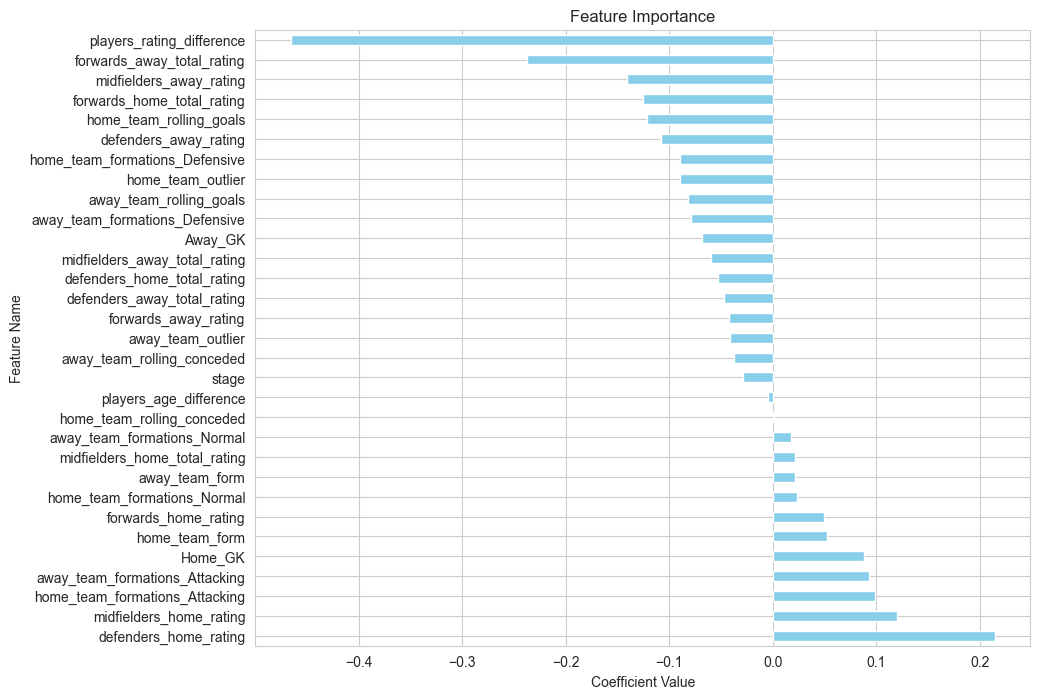

In [7]:
plt.figure(figsize=(10, 8))
coefficients_df['Coefficient'].plot(kind='barh', color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.show()

Now, we will generate a plot to illustrate the variance explained by each component. This will aid us in determining the number of components to utilize in Principal Component Analysis (PCA).

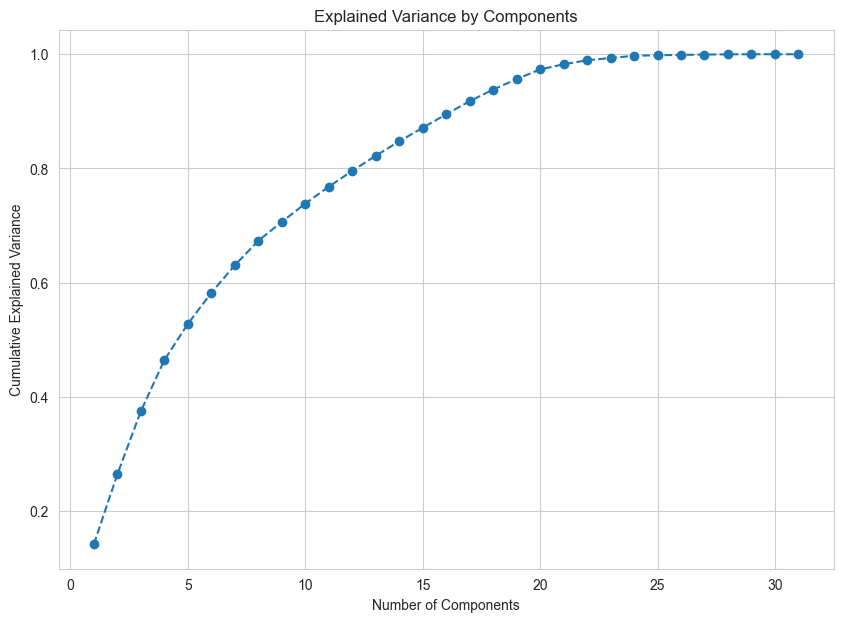

In [8]:
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)

pca = PCA()
pca.fit(features_train_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

The observation is that 20 components account for approximately 90% of the variance. Therefore, we will employ 20 components in our Principal Component Analysis (PCA).

## Model Tuning

We will employ GridSearchCV for model optimization, utilizing precision as our evaluation metric. Our primary interest lies in accurately predicting 'under,' hence minimizing false positives is crucial. Additionally, we will implement Principal Component Analysis (PCA) to decrease the number of features.

In [9]:
pca = PCA(n_components=20)

pipeline = Pipeline(steps=[('s', StandardScaler()), ('pca', pca), ('m', LogisticRegression(max_iter=1000))])

param_grid = {
    'm__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

custom_scorer = make_scorer(precision_score, pos_label='U')

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=custom_scorer)
grid_search.fit(features_train, target_train)

print("Best parameters: ", grid_search.best_params_)
print("Best precision: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
predicted_test = best_model.predict(features_test)

report = classification_report(target_test, predicted_test)

print(report)

Best parameters:  {'m__C': 0.01}
Best precision:  0.5341676052033877
              precision    recall  f1-score   support

           O       0.55      0.34      0.42       914
           U       0.52      0.72      0.60       908

    accuracy                           0.53      1822
   macro avg       0.53      0.53      0.51      1822
weighted avg       0.53      0.53      0.51      1822


We have improved recall for under, but the precision stayed the same. We will examine the ROC AUC score, ROC curve, and confusion matrix.

## ROC AUC score Roc curve and confusion matrix

- ROC AUC Score

The ROC AUC Score, or Receiver Operating Characteristic Area Under the Curve, is a performance measurement for classification problems at various threshold settings. It tells how much a model is capable of distinguishing between classes. The higher the AUC, the better the model predicts Us as Us and Os as Os. 

An AUC score of 0.5 suggests no discrimination, i.e., the model cannot distinguish between positive and negative instances. An AUC score of 1.0 is perfect, where the model has ideal discrimination capability.

In [10]:
from sklearn.metrics import roc_auc_score

predicted_prob = best_model.predict_proba(features_test)[:, 1]

roc_auc = roc_auc_score(target_test, predicted_prob)

print("ROC AUC Score: ", roc_auc)

ROC AUC Score:  0.5492594395550372


An ROC AUC Score of 0.549 indicates that our model possesses a marginal capability to differentiate between the classes, however, it's not particularly effective.

- ROC Curve

The ROC curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity. The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test. The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

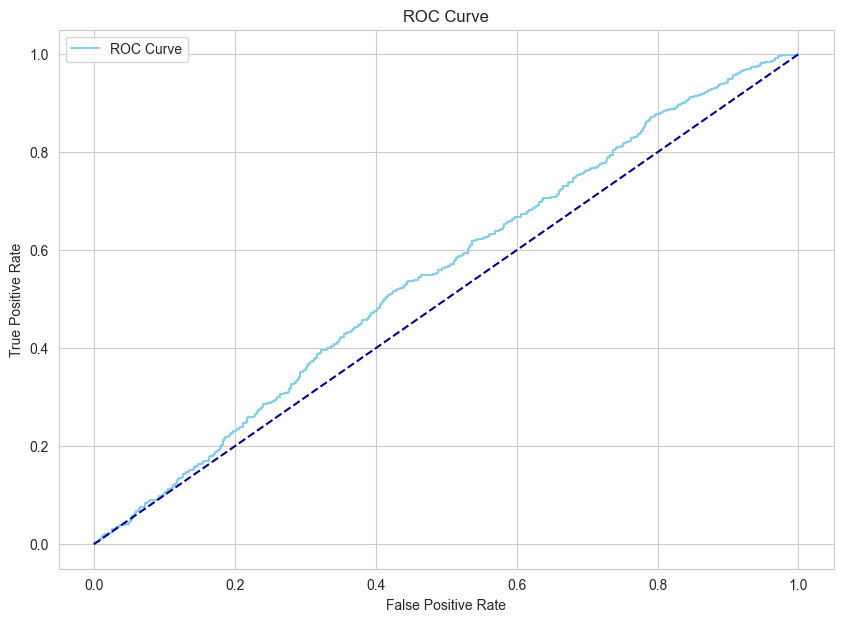

In [11]:
fpr, tpr, thresholds = roc_curve(target_test, predicted_prob, pos_label='U')

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='skyblue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

- Confusion Matrix

A confusion matrix, sometimes referred to as an error matrix, is a specific type of table that provides a visual representation of an algorithm's performance. It is typically used in supervised learning. This table, consisting of two rows and two columns, displays the counts of true positives, true negatives, false positives, and false negatives. This matrix offers a more comprehensive analysis than simply looking at the proportion of correct classifications, also known as accuracy.

Here's a brief explanation of these terms:

- **True Positives (TP)**: These are cases in which we predicted yes (Under), and the actual output was also yes (Under).

- **True Negatives (TN)**: We predicted no (Over), and the actual output was no (Over).

- **False Positives (FP)**: We predicted yes (Under), but the actual output was no (Over). Also known as "Type I error".

- **False Negatives (FN)**: We predicted no (Over), but the actual output was yes (Under). This is also known as "Type II error."

The layout of a confusion matrix can be visualized as follows:

|                    | Predicted: Yes (Under) | Predicted: No (Over) |
|--------------------|------------------------|----------------------|
| Actual: Yes (Under)| True Positive (TP)     | False Negative (FN)  |
| Actual: No (Over)  | False Positive (FP)    | True Negative (TN)   |

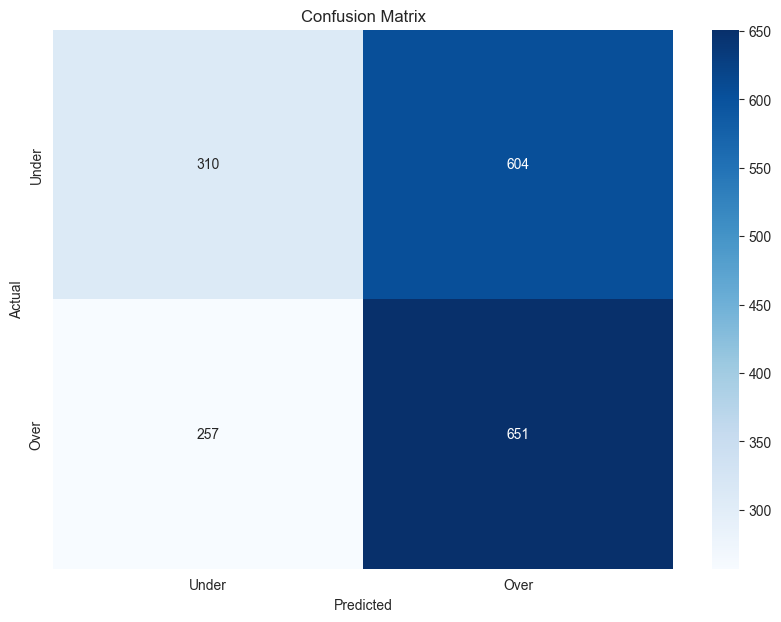

In [12]:
predicted_classes = best_model.predict(features_test)

cm = confusion_matrix(target_test, predicted_classes)

class_labels = ['Under', 'Over']

cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The confusion matrix indicates that our model is not particularly effective at distinguishing between the classes. It is unable to accurately predict 'Under' and 'Over' goals.

# Summary

The `goals_model` is a binary classification model that forecasts whether the total number of goals in a football match will be 'Under' or 'Over' a certain threshold. This model was trained on a dataset that includes match data from the top 5 leagues. The model's target variable, 'goals_target', is a binary variable that indicates whether a match ended with 'Under' or 'Over' goals.

In the context of this model, 'Under' and 'Over' are terms used in sports betting. 'Under' means that the total number of goals scored by both teams in a match is 2 or less, while 'Over' means that the total number of goals scored is 3 or more.

The model was trained using a variety of machine learning algorithms, including Logistic Regression, Random Forest, Support Vector Machine, K-Nearest Neighbors, and Gradient Boosting. After evaluating the performance of these models, Logistic Regression was selected as the most effective model for predicting 'Under' goals.

The Logistic Regression model was further refined using GridSearchCV, with precision as the evaluation metric. Principal Component Analysis (PCA) was also applied to decrease the number of features. The model was adjusted to minimize false positives, which is essential for accurately predicting 'Under' goals.

The model's performance was assessed using the ROC AUC score, ROC curve, and confusion matrix. The ROC AUC score of 0.549 suggests that the model has a slight ability to distinguish between the classes. The ROC curve and confusion matrix further corroborate that the model is not particularly adept at differentiating between 'Under' and 'Over' goals.

Despite its low precision, the model could still be beneficial for profiting from betting companies. This is akin to the home team win model, where a model with low precision was still able to turn a profit. However, without data from betting companies, it's impossible to definitively determine whether this model would be profitable.

# Suggestions for Improvement

For further enhancement of the model, the following strategies could be considered:

1. **Ensemble Methods**: These methods combine the predictions of multiple models to improve the overall performance. Experiment with ensemble methods and base classifiers to see which combination gives the best results.

2. **Deep Learning**: Deep learning models, such as neural networks, can capture complex patterns in the data. Experiment with different architectures, activation functions, and other hyperparameters to optimize the performance of the deep learning model.

3. **Bayesian Optimization**: This is an advanced method for hyperparameter tuning. It builds a probabilistic model of the function mapping from hyperparameter values to the objective evaluated on a validation set. Then, it uses this model to select the hyperparameters expected to perform best in the next round.

4. **Data Collection**: Acquiring additional data, mainly focusing on game statistics, could also enhance the model's performance. This could involve gathering more detailed data about player performance, team strategies, or other match-specific details. Expanding the dataset with these additional features could provide a more comprehensive view of the game dynamics, potentially leading to improved model predictions.